In [1]:
## modules to obtain dataset from Planetary Computer
import planetary_computer
import pystac_client
import fsspec


## modules to process the data
import xarray as xr
import eumartools
import numpy as np

## modules for plotting
import matplotlib.pyplot as plt
from matplotlib import colors
import cartopy 
import cartopy.crs as ccrs
import colormaps as cmo


## additional modules to display or print information in Python
from datetime import datetime
from IPython.display import display, Markdown
def printmd(string):
    display(Markdown(string))

import os

from tqdm.auto import tqdm

from rich import print as rprint

In [2]:
# Datetime format used: YYYY-MM-DD. Start-time/End-time.
time_of_interest = "2023-01-01/2023-01-02"

# Location coordinates using decimal format.
west = 106.3640
east = 107.1060
north = -5.1350
south = -6.1810

In [3]:
area_of_interest = {
    "type": "Polygon",
    "coordinates": [
        [
            [west, south],
            [east, south],
            [east, north],
            [west, north],
            [west, south],
        ]
    ],
}

subset_box_lons = [west, west, east, east, west]
subset_box_lats = [south, north, north, south, south]

extent = [west, east, south, north]

In [4]:
catalog = pystac_client.Client.open("https://planetarycomputer.microsoft.com/api/stac/v1", modifier=planetary_computer.sign_inplace)

search = catalog.search(collections=["sentinel-3-olci-wfr-l2-netcdf"], intersects=area_of_interest, datetime=time_of_interest)

In [5]:
# Check how many items were returned

items = search.item_collection()

printmd(f"For selected time and locaton of interest, there are **{len(items)}** items available.") 
printmd(f"First data is from `{items[-1].properties['datetime']}` and last data `{items[0].properties['datetime']}`")

For selected time and locaton of interest, there are **3** items available.

First data is from `2023-01-01T02:47:51.435039Z` and last data `2023-01-02T03:00:47.245924Z`

In [6]:
keys_1 = ["chl-nn","tsm-nn","chl-oc4me"]

keys_2 = [
    "oa06-reflectance",
    "oa07-reflectance",
    "oa08-reflectance",
    "oa09-reflectance",
    "oa10-reflectance",
    "oa11-reflectance",
    "oa12-reflectance",
]


In [10]:
for index, item in tqdm(enumerate(items, start=0), desc='Processed', total=len(items)):

# Acquire the time properties

    date_string = item.properties['datetime']
    time_object = datetime.strptime(date_string, '%Y-%m-%dT%H:%M:%S.%fZ')

# Subset data to area of interest

    geo_fid = xr.open_dataset(fsspec.open(item.assets["geo-coordinates"].href).open())

    lon_i = geo_fid.longitude.data
    lat_i = geo_fid.latitude.data

    ii, jj, region_mask = eumartools.subset_image(lon_i, lat_i, subset_box_lons, subset_box_lats) 

    lon_ii = lon_i[min(jj):max(jj), min(ii):max(ii)]
    lat_ii = lat_i[min(jj):max(jj), min(ii):max(ii)]

    lon = xr.DataArray(lon_ii, coords=None, dims=['y', 'x'])
    lon.attrs = {
        'units' : 'degrees_east',
        'unit_long' : "Degrees East",
        'standard_name' : "longitude",
        'long_name' : "Longitude",
        'axis' : 'X'
    }

    lat = xr.DataArray(lat_ii, coords=None, dims=['y', 'x'])
    lat.attrs = {
        'units' : 'degrees_east',
        'unit_long' : "Degrees North",
        'standard_name' : "latitude",
        'long_name' : "Latitude",
        'axis' : 'Y'
    }

# Create a land mask

    flag_file = fsspec.open(item.assets['wqsf'].href).open()

    land_mask = eumartools.flag_mask(flag_file, 'WQSF', ['LAND','INLAND_WATER','TIDAL']) # prior to 2021, flag 'COASTLINE', is not available.
    land_mask = land_mask.astype(float)[min(jj):max(jj), min(ii):max(ii)]
    # land_mask[land_mask == 0.0] = np.nan
    land_mask_da = xr.DataArray(land_mask, coords=None, dims=['y', 'x'])

    land = xr.Dataset()

    land['lon'] = lon
    land['lat'] = lat
    land['mask'] = land_mask_da

    land = land.set_coords(['lon', 'lat'])
    land = land.expand_dims(dim={"time":[time_object]}, axis=0)

    comp = dict(zlib=True, complevel=4)
    encoding_land = {var: comp for var in land.data_vars}

    land.to_netcdf(
        os.path.join(os.getcwd(), 'output', f'{item.id}_LAND.nc'), 
        format='NETCDF4', 
        unlimited_dims=['time'],
        encoding=encoding_land
        )

# Flags

    flag_nn = eumartools.flag_mask(flag_file, 'WQSF',
                                   ['LAND', 'CLOUD', 'CLOUD_AMBIGUOUS', 'CLOUD_MARGIN', 'INVALID', 'COSMETIC', 'SATURATED', 'SUSPECT', 'HISOLZEN', 'HIGHGLINT', 'SNOW_ICE', 'AC_FAIL','WHITECAPS', 'ADJAC', 'RWNEG_O2', 'RWNEG_O3','RWNEG_O4', 'RWNEG_O5', 'RWNEG_O6', 'RWNEG_O7', 'RWNEG_O8','OCNN_FAIL']
                                   )

    flag_nn = flag_nn.astype(float)[min(jj):max(jj), min(ii):max(ii)]
    flag_nn[flag_nn == 0.0] = np.nan

    flag_oc = eumartools.flag_mask(flag_file, 'WQSF',
                                   ['LAND', 'CLOUD', 'CLOUD_AMBIGUOUS', 'CLOUD_MARGIN', 'INVALID', 'COSMETIC', 'SATURATED', 'SUSPECT', 'HISOLZEN', 'HIGHGLINT', 'SNOW_ICE', 'AC_FAIL','WHITECAPS', 'ADJAC', 'RWNEG_O2', 'RWNEG_O3','RWNEG_O4', 'RWNEG_O5', 'RWNEG_O6', 'RWNEG_O7', 'RWNEG_O8','OC4ME_FAIL']
                                   )

    flag_oc = flag_oc.astype(float)[min(jj):max(jj), min(ii):max(ii)]
    flag_oc[flag_oc == 0.0] = np.nan

    flag_re_06 = eumartools.flag_mask(flag_file, 'WQSF',
                                   ['LAND', 'CLOUD', 'CLOUD_AMBIGUOUS', 'CLOUD_MARGIN', 'INVALID', 'COSMETIC', 'SATURATED', 'SUSPECT', 'HISOLZEN', 'HIGHGLINT', 'SNOW_ICE', 'AC_FAIL','WHITECAPS', 'ADJAC', 'RWNEG_O6']
                                   )

    flag_re_06 = flag_re_06.astype(float)[min(jj):max(jj), min(ii):max(ii)]
    flag_re_06[flag_re_06 == 0.0] = np.nan

    flag_re_07 = eumartools.flag_mask(flag_file, 'WQSF',
                                   ['LAND', 'CLOUD', 'CLOUD_AMBIGUOUS', 'CLOUD_MARGIN', 'INVALID', 'COSMETIC', 'SATURATED', 'SUSPECT', 'HISOLZEN', 'HIGHGLINT', 'SNOW_ICE', 'AC_FAIL','WHITECAPS', 'ADJAC', 'RWNEG_O7']
                                   )

    flag_re_07 = flag_re_07.astype(float)[min(jj):max(jj), min(ii):max(ii)]
    flag_re_07[flag_re_07 == 0.0] = np.nan

    flag_re_08 = eumartools.flag_mask(flag_file, 'WQSF',
                                   ['LAND', 'CLOUD', 'CLOUD_AMBIGUOUS', 'CLOUD_MARGIN', 'INVALID', 'COSMETIC', 'SATURATED', 'SUSPECT', 'HISOLZEN', 'HIGHGLINT', 'SNOW_ICE', 'AC_FAIL','WHITECAPS', 'ADJAC', 'RWNEG_O8']
                                   )

    flag_re_08 = flag_re_08.astype(float)[min(jj):max(jj), min(ii):max(ii)]
    flag_re_08[flag_re_08 == 0.0] = np.nan

    flag_re_09 = eumartools.flag_mask(flag_file, 'WQSF',
                                   ['LAND', 'CLOUD', 'CLOUD_AMBIGUOUS', 'CLOUD_MARGIN', 'INVALID', 'COSMETIC', 'SATURATED', 'SUSPECT', 'HISOLZEN', 'HIGHGLINT', 'SNOW_ICE', 'AC_FAIL','WHITECAPS', 'ADJAC', 'RWNEG_O9']
                                   )

    flag_re_09 = flag_re_09.astype(float)[min(jj):max(jj), min(ii):max(ii)]
    flag_re_09[flag_re_09 == 0.0] = np.nan

    flag_re_10 = eumartools.flag_mask(flag_file, 'WQSF',
                                   ['LAND', 'CLOUD', 'CLOUD_AMBIGUOUS', 'CLOUD_MARGIN', 'INVALID', 'COSMETIC', 'SATURATED', 'SUSPECT', 'HISOLZEN', 'HIGHGLINT', 'SNOW_ICE', 'AC_FAIL','WHITECAPS', 'ADJAC', 'RWNEG_O10']
                                   )

    flag_re_10 = flag_re_10.astype(float)[min(jj):max(jj), min(ii):max(ii)]
    flag_re_10[flag_re_10 == 0.0] = np.nan

    flag_re_11 = eumartools.flag_mask(flag_file, 'WQSF',
                                   ['LAND', 'CLOUD', 'CLOUD_AMBIGUOUS', 'CLOUD_MARGIN', 'INVALID', 'COSMETIC', 'SATURATED', 'SUSPECT', 'HISOLZEN', 'HIGHGLINT', 'SNOW_ICE', 'AC_FAIL','WHITECAPS', 'ADJAC', 'RWNEG_O11']
                                   )

    flag_re_11 = flag_re_11.astype(float)[min(jj):max(jj), min(ii):max(ii)]
    flag_re_11[flag_re_11 == 0.0] = np.nan

    flag_re_12 = eumartools.flag_mask(flag_file, 'WQSF',
                                   ['LAND', 'CLOUD', 'CLOUD_AMBIGUOUS', 'CLOUD_MARGIN', 'INVALID', 'COSMETIC', 'SATURATED', 'SUSPECT', 'HISOLZEN', 'HIGHGLINT', 'SNOW_ICE', 'AC_FAIL','WHITECAPS', 'ADJAC', 'RWNEG_O12']
                                   )

    flag_re_12 = flag_re_12.astype(float)[min(jj):max(jj), min(ii):max(ii)]
    flag_re_12[flag_re_12 == 0.0] = np.nan

    ## BIOGEOCHEMICAL PROPERTIES

    biog = [xr.open_dataset(fsspec.open(item.assets[k].href).open()) for k in keys_1]
    ds_biog = xr.combine_by_coords(biog, join="exact", combine_attrs="drop_conflicts")

    chl_nn = np.array(ds_biog['CHL_NN'].data[min(jj):max(jj), min(ii):max(ii)])
    chl_nn[flag_nn == 1] = np.nan

    tsm_nn = np.array(ds_biog['TSM_NN'].data[min(jj):max(jj), min(ii):max(ii)])
    tsm_nn[flag_nn == 1] = np.nan

    chl_oc = np.array(ds_biog['CHL_OC4ME'].data[min(jj):max(jj), min(ii):max(ii)])
    chl_oc[flag_oc == 1] = np.nan

    chl_nn_da = xr.DataArray(chl_nn, coords=None, dims=['y', 'x'])
    chl_nn_da.attrs = ds_biog.CHL_NN.attrs
    chl_oc_da = xr.DataArray(chl_nn, coords=None, dims=['y', 'x'])
    chl_oc_da.attrs = ds_biog.CHL_OC4ME.attrs
    tsm_nn_da = xr.DataArray(chl_nn, coords=None, dims=['y', 'x'])
    tsm_nn_da.attrs = ds_biog.TSM_NN.attrs

    # Create xarray dataset and save to netCDF format.

    chl_ds = xr.Dataset()

    chl_ds['lon'] = lon
    chl_ds['lat'] = lat
    chl_ds['chl_nn'] = chl_nn_da
    chl_ds['chl_oc'] = chl_oc_da
    chl_ds['tsm_nn'] = tsm_nn_da

    chl_ds = chl_ds.set_coords(['lon', 'lat'])
    chl_ds = chl_ds.expand_dims(dim={"time":[time_object]}, axis=0)

    comp = dict(zlib=True, complevel=4, _FillValue=-9999.)
    encoding = {var: comp for var in chl_ds.data_vars}

    chl_ds.to_netcdf(
        os.path.join(os.getcwd(), 'output', f'{item.id}_BIOGEOCHEMISTRY.nc'), 
        format='NETCDF4', 
        unlimited_dims=['time'],
        encoding=encoding
        )

## REFLECTANCE

    refl = [xr.open_dataset(fsspec.open(item.assets[k].href).open()) for k in keys_2]
    ds_refl = xr.combine_by_coords(refl, join="exact", combine_attrs="drop_conflicts")

    Oa06 = np.array(ds_refl['Oa06_reflectance'].data[min(jj):max(jj), min(ii):max(ii)])
    Oa06[flag_re_06 == 1] = np.nan
    Oa07 = np.array(ds_refl['Oa07_reflectance'].data[min(jj):max(jj), min(ii):max(ii)])
    Oa07[flag_re_07 == 1] = np.nan
    Oa08 = np.array(ds_refl['Oa08_reflectance'].data[min(jj):max(jj), min(ii):max(ii)])
    Oa08[flag_re_08 == 1] = np.nan
    Oa09 = np.array(ds_refl['Oa09_reflectance'].data[min(jj):max(jj), min(ii):max(ii)])
    Oa09[flag_re_09 == 1] = np.nan
    Oa10 = np.array(ds_refl['Oa10_reflectance'].data[min(jj):max(jj), min(ii):max(ii)])
    Oa10[flag_re_10 == 1] = np.nan
    Oa11 = np.array(ds_refl['Oa11_reflectance'].data[min(jj):max(jj), min(ii):max(ii)])
    Oa11[flag_re_11 == 1] = np.nan
    Oa12 = np.array(ds_refl['Oa12_reflectance'].data[min(jj):max(jj), min(ii):max(ii)])
    Oa12[flag_re_12 == 1] = np.nan

    ds_refl.close()
    del refl
    
    Oa06_da = xr.DataArray(Oa06, coords=None, dims=['y', 'x'])
    Oa06_da.attrs = ds_refl.Oa06_reflectance.attrs

    Oa07_da = xr.DataArray(Oa07, coords=None, dims=['y', 'x'])
    Oa07_da.attrs = ds_refl.Oa07_reflectance.attrs

    Oa08_da = xr.DataArray(Oa08, coords=None, dims=['y', 'x'])
    Oa08_da.attrs = ds_refl.Oa08_reflectance.attrs

    Oa09_da = xr.DataArray(Oa09, coords=None, dims=['y', 'x'])
    Oa09_da.attrs = ds_refl.Oa09_reflectance.attrs

    Oa10_da = xr.DataArray(Oa10, coords=None, dims=['y', 'x'])
    Oa10_da.attrs = ds_refl.Oa10_reflectance.attrs

    Oa11_da = xr.DataArray(Oa11, coords=None, dims=['y', 'x'])
    Oa11_da.attrs = ds_refl.Oa11_reflectance.attrs

    Oa12_da = xr.DataArray(Oa12, coords=None, dims=['y', 'x'])
    Oa12_da.attrs = ds_refl.Oa12_reflectance.attrs

    ref_ds = xr.Dataset()

    ref_ds['lon'] = lon
    ref_ds['lat'] = lat

    ref_ds['Oa06'] = Oa06_da
    ref_ds['Oa07'] = Oa07_da
    ref_ds['Oa08'] = Oa08_da
    ref_ds['Oa09'] = Oa09_da
    ref_ds['Oa10'] = Oa10_da
    ref_ds['Oa11'] = Oa11_da
    ref_ds['Oa12'] = Oa12_da

    ref_ds = ref_ds.set_coords(['lon', 'lat'])

    ref_ds = ref_ds.expand_dims(dim={"time":[time_object]}, axis=0)
    
    comp = dict(zlib=True, _FillValue=-99999.0, complevel=4)
    encoding = {var: comp for var in ref_ds.data_vars}

    ref_ds.to_netcdf(
        os.path.join(os.getcwd(), 'output',f'{item.id}_REFLECTANCES.nc'), 
        format='NETCDF4', 
        unlimited_dims=['time'],
        encoding=encoding
        )
    
    ref_ds.close()



Processed:   0%|          | 0/3 [00:00<?, ?it/s]

Plot to examine the processed data.

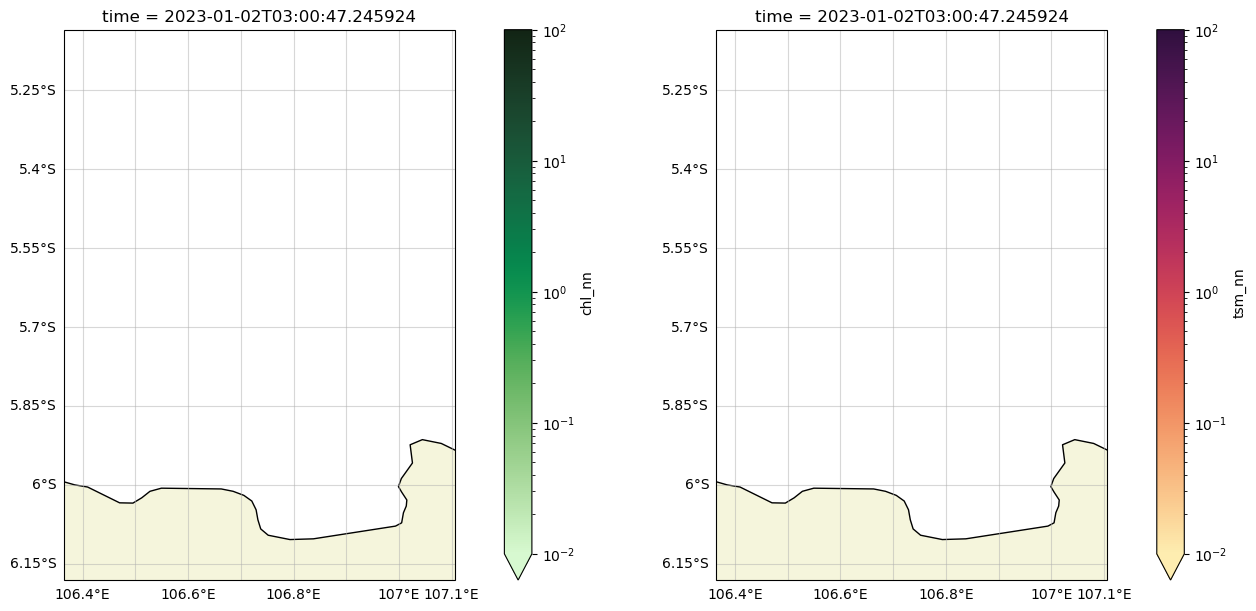

In [11]:
for_plot = xr.open_dataset(os.path.join(os.getcwd(), 'output',f'{items[0].id}_BIOGEOCHEMISTRY.nc'))

for_plot['chl_nn'] = 10 ** for_plot['chl_nn'] 
for_plot['tsm_nn'] = 10 ** for_plot['tsm_nn'] 

fig, ax = plt.subplots(figsize=[13,6], ncols=2, layout='constrained', subplot_kw=dict(projection=ccrs.Mercator()))

for i in range(2):
    ax[i].set_extent(extent)
    ax[i].add_feature(cartopy.feature.LAND.with_scale('10m'), facecolor = 'beige', edgecolor='black', zorder = 1)

    ini = ax[i].gridlines(draw_labels = True, alpha=0.5)
    ini.top_labels = False
    ini.right_labels = False

for_plot.chl_nn.isel(time=0).plot.pcolormesh(x='lon', y='lat', ax=ax[0], norm=colors.LogNorm(0.01,100), cmap=cmo.algae, zorder=0, transform=ccrs.PlateCarree())
for_plot.tsm_nn.isel(time=0).plot.pcolormesh(x='lon', y='lat', ax=ax[1], norm=colors.LogNorm(0.01,100), cmap=cmo.matter, zorder=0, transform=ccrs.PlateCarree())

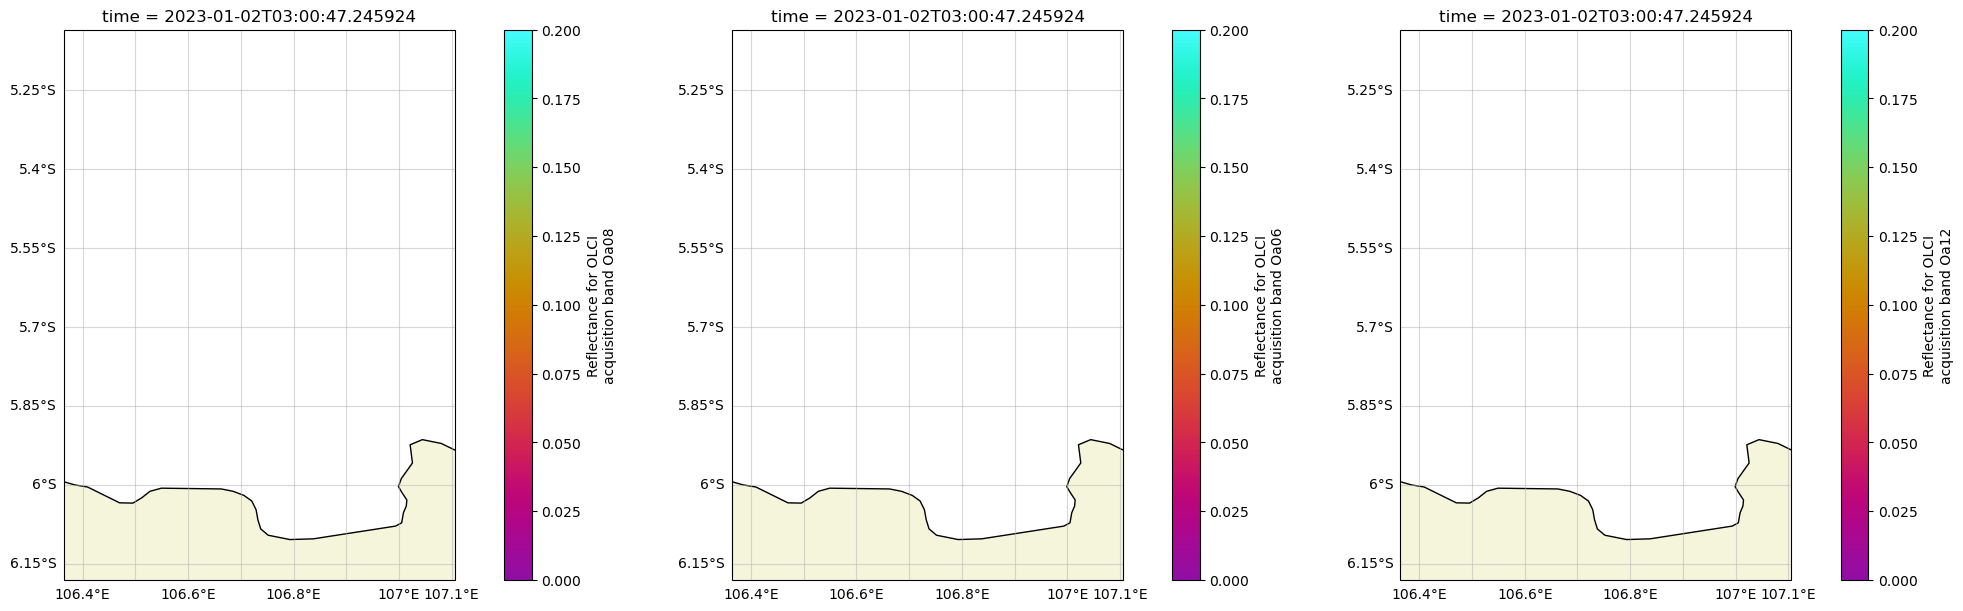

In [12]:
ref_ds = xr.open_dataset(os.path.join(os.getcwd(), 'output',f'{items[0].id}_REFLECTANCES.nc'))

fig, ax = plt.subplots(figsize=[20,6], ncols=3, layout='constrained', subplot_kw=dict(projection=ccrs.Mercator()))

for i in range(3):
    ax[i].set_extent(extent)
    ax[i].add_feature(cartopy.feature.LAND.with_scale('10m'), facecolor = 'beige', edgecolor='black', zorder = 1)

    ini = ax[i].gridlines(draw_labels = True, alpha=0.5)
    ini.top_labels = False
    ini.right_labels = False

ref_ds.Oa08.isel(time=0).plot.pcolormesh(x='lon', y='lat', ax=ax[0], norm=colors.Normalize(0, 0.2), cmap=cmo.tropical, zorder=0, transform=ccrs.PlateCarree())
ref_ds.Oa06.isel(time=0).plot.pcolormesh(x='lon', y='lat', ax=ax[1], norm=colors.Normalize(0, 0.2), cmap=cmo.tropical, zorder=0, transform=ccrs.PlateCarree())
ref_ds.Oa12.isel(time=0).plot.pcolormesh(x='lon', y='lat', ax=ax[2], norm=colors.Normalize(0, 0.2), cmap=cmo.tropical, zorder=0, transform=ccrs.PlateCarree())

